# Prepare

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *

2022-05-17 14:29:09.717679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Load

In [2]:
## 경로 설정
small_train_images_path = './data/PREPROCESSING-TRAIN'
small_test_images_path = './data/PREPROCESSING-TEST'
data_path = './data'

train_images_name = sorted(os.listdir(small_train_images_path))
train_images_path = \
[os.path.join(small_train_images_path, name) for name in train_images_name]

test_images_name = sorted(os.listdir(small_test_images_path))
test_images_path = \
[os.path.join(small_test_images_path, name) for name in test_images_name]

label_dfs = []
case_names = sorted(os.listdir('./data/train'))

for case in case_names :
    label_path = data_path+'/train/'+case+'/label-{}.csv'.format(str(int(case[-2:])))
    df = pd.read_csv(label_path)
    label_dfs.append(df)
    
label_df = pd.concat(label_dfs, axis=0)
label_df.to_csv('./data/labels.csv', index=False)

label_df.set_index('img_name', inplace=True)

label_df['img_path'] = train_images_path

shuffled_df = label_df.sample(frac=1)

# Data Generator

In [3]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(shuffled_df)*0.8)

train_df = shuffled_df[:train_len]
valid_df = shuffled_df[train_len:]

train_img_path = train_df['img_path'].to_list()
train_label = train_df['leaf_weight'].to_list()

valid_img_path = valid_df['img_path'].to_list()
valid_label = valid_df['leaf_weight'].to_list()

In [4]:
%%time
train_img = np.array(list(map(cv2.imread, train_img_path)))
valid_img = np.array(list(map(cv2.imread, valid_img_path)))

CPU times: user 11.3 s, sys: 2.61 s, total: 13.9 s
Wall time: 15.4 s


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
BATCH_SIZE = 19

train_generator = train_datagen.flow(train_img,
                                    train_label,
                                    batch_size=BATCH_SIZE)

valid_generator = test_datagen.flow(valid_img,
                                    valid_label,
                                   batch_size=BATCH_SIZE)

In [7]:
IMAGE_SIZE = 512
MODEL_IMAGE_SIZE = 299

# Definitions

In [8]:
def NMAE(y_true, y_pred) :
    error = y_true - y_pred
    absolute_error = tf.abs(error)
    return tf.reduce_mean(absolute_error) / tf.reduce_mean(y_true)

def nmae(y_true, y_pred):
    score = tf.py_function(func=NMAE, inp=[y_true, y_pred], Tout=tf.float32, name='nmae')
    return score

<h1> inception_v2_resnet 0.01 adam 0.2 </h1>
<img src='./Training_Result/inception_v2_resnet 0.01 adam 0.2.png'/>

In [9]:
base_model = inception_resnet_v2.InceptionResNetV2(
            weights='imagenet',
            include_top = False,
            input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3))

input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
output_data = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=output_data, name='resize')

# model
inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)
model = Model(inputs, outputs)

base_model.trainable = False
model.summary()

2022-05-17 14:29:32.428954: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-17 14:29:32.485764: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-17 14:29:32.560058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 14:29:32.562068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-17 14:29:32.562465: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-17 14:29:32.652222: I tensorflow/stream_executor/platform/default/dso_loade

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resize (Functional)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025  

In [10]:
model.compile(optimizer=Adam(0.01),
            loss='mae',
            metrics=[nmae])

es = EarlyStopping(monitor='loss',
                mode='auto',
                patience=5,
                verbose=1)

ckpt_path = './Best_Check_Point/best_params1_top_layers.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_nmae',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
VAL_STEPS = len(valid_img) // BATCH_SIZE

history = model.fit(train_generator, epochs=2000,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  validation_data=valid_generator,
                  validation_steps = VAL_STEPS,
                  callbacks=[checkpointer, es],
                  verbose=1)

2022-05-17 14:29:41.979305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-17 14:29:42.001648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/2000


2022-05-17 14:29:49.688851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-17 14:29:50.587797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


67/67 [==============================] - 79s 1s/step - loss: 36.1472 - nmae: 0.4553 - val_loss: 19.2146 - val_nmae: 0.2354

Epoch 00001: val_nmae improved from inf to 0.23545, saving model to ./Best_Check_Point/best_params1_top_layers.ckpt
Epoch 2/2000
67/67 [==============================] - 66s 976ms/step - loss: 15.6074 - nmae: 0.1973 - val_loss: 14.7266 - val_nmae: 0.1769

Epoch 00002: val_nmae improved from 0.23545 to 0.17689, saving model to ./Best_Check_Point/best_params1_top_layers.ckpt
Epoch 3/2000
67/67 [==============================] - 66s 980ms/step - loss: 14.2599 - nmae: 0.1826 - val_loss: 17.1865 - val_nmae: 0.2266

Epoch 00003: val_nmae did not improve from 0.17689
Epoch 4/2000
67/67 [==============================] - 65s 975ms/step - loss: 13.1329 - nmae: 0.1739 - val_loss: 14.6932 - val_nmae: 0.1749

Epoch 00004: val_nmae improved from 0.17689 to 0.17490, saving model to ./Best_Check_Point/best_params1_top_layers.ckpt
Epoch 5/2000
67/67 [=============================

In [11]:
model.save('./Model_Save/best1_top_layer.h5')

In [12]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
train_nmae = history.history['nmae']
valid_nmae = history.history['val_nmae']

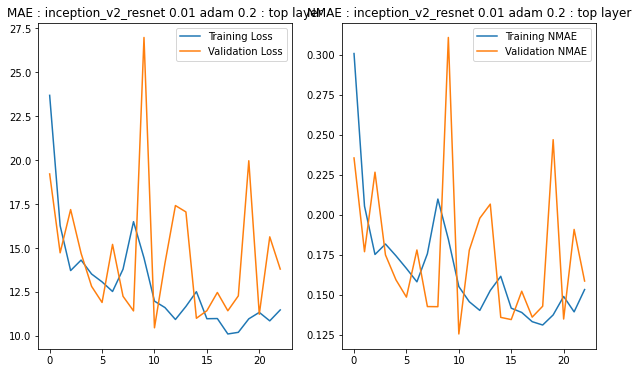

In [13]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 : top layer')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 : top layer')

plt.show()

### finetune

In [14]:
history_dict = {}

Epoch 1/2000
67/67 [==============================] - 76s 1s/step - loss: 231.3031 - nmae: 3.6799 - val_loss: 16.2300 - val_nmae: 0.1924

Epoch 00001: val_nmae improved from inf to 0.19238, saving model to ./Best_Check_Point/best_params1_finetune_0.9.ckpt
Epoch 2/2000
67/67 [==============================] - 66s 977ms/step - loss: 17.5188 - nmae: 0.2323 - val_loss: 12.6547 - val_nmae: 0.1536

Epoch 00002: val_nmae improved from 0.19238 to 0.15361, saving model to ./Best_Check_Point/best_params1_finetune_0.9.ckpt
Epoch 3/2000
67/67 [==============================] - 66s 977ms/step - loss: 16.3782 - nmae: 0.2010 - val_loss: 10.6496 - val_nmae: 0.1322

Epoch 00003: val_nmae improved from 0.15361 to 0.13220, saving model to ./Best_Check_Point/best_params1_finetune_0.9.ckpt
Epoch 4/2000
67/67 [==============================] - 66s 979ms/step - loss: 20.0623 - nmae: 0.2475 - val_loss: 19.3272 - val_nmae: 0.2338

Epoch 00004: val_nmae did not improve from 0.13220
Epoch 5/2000
67/67 [=========

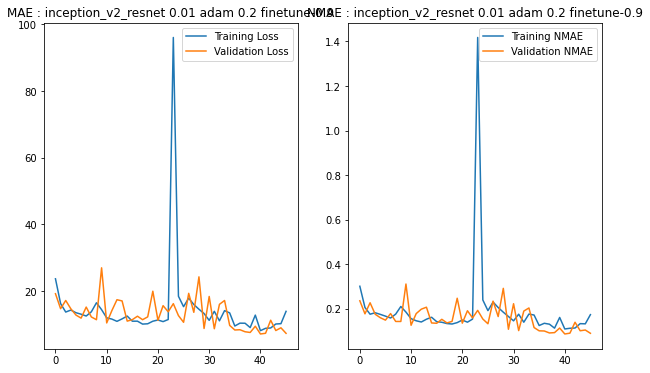

Epoch 1/2000
67/67 [==============================] - 78s 1s/step - loss: 934.8070 - nmae: 9.6820 - val_loss: 83.9411 - val_nmae: 0.9839

Epoch 00001: val_nmae improved from inf to 0.98387, saving model to ./Best_Check_Point/best_params1_finetune_0.7.ckpt
Epoch 2/2000
67/67 [==============================] - 66s 983ms/step - loss: 78.8818 - nmae: 0.9913 - val_loss: 57.7569 - val_nmae: 0.6936

Epoch 00002: val_nmae improved from 0.98387 to 0.69357, saving model to ./Best_Check_Point/best_params1_finetune_0.7.ckpt
Epoch 3/2000
67/67 [==============================] - 66s 984ms/step - loss: 64.4702 - nmae: 0.8437 - val_loss: 84.1463 - val_nmae: 0.9945

Epoch 00003: val_nmae did not improve from 0.69357
Epoch 4/2000
67/67 [==============================] - 66s 984ms/step - loss: 76.2498 - nmae: 0.9862 - val_loss: 85.0526 - val_nmae: 0.9935

Epoch 00004: val_nmae did not improve from 0.69357
Epoch 5/2000
67/67 [==============================] - 66s 987ms/step - loss: 77.1728 - nmae: 1.0035 

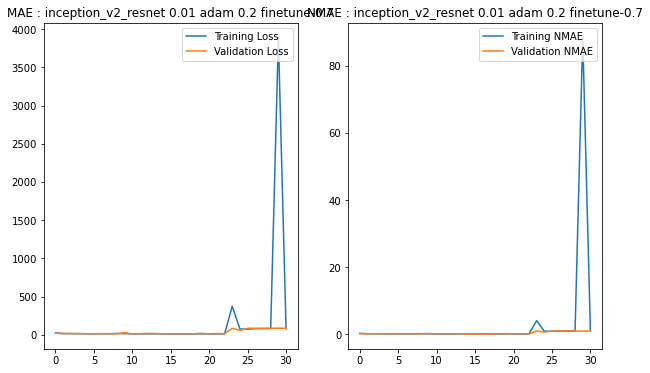

Epoch 1/2000
67/67 [==============================] - 79s 1s/step - loss: 216.3431 - nmae: 2.5655 - val_loss: 83.6147 - val_nmae: 1.0000

Epoch 00001: val_nmae improved from inf to 1.00000, saving model to ./Best_Check_Point/best_params1_finetune_0.5.ckpt
Epoch 2/2000
67/67 [==============================] - 66s 986ms/step - loss: 78.7906 - nmae: 1.0000 - val_loss: 84.2922 - val_nmae: 1.0000

Epoch 00002: val_nmae did not improve from 1.00000
Epoch 3/2000
67/67 [==============================] - 66s 984ms/step - loss: 78.1245 - nmae: 1.0000 - val_loss: 84.3750 - val_nmae: 1.0000

Epoch 00003: val_nmae did not improve from 1.00000
Epoch 4/2000
67/67 [==============================] - 67s 1s/step - loss: 80.8178 - nmae: 1.0000 - val_loss: 86.0423 - val_nmae: 1.0000

Epoch 00004: val_nmae did not improve from 1.00000
Epoch 5/2000
67/67 [==============================] - 66s 987ms/step - loss: 79.2745 - nmae: 1.0000 - val_loss: 83.5477 - val_nmae: 1.0000

Epoch 00005: val_nmae did not impr

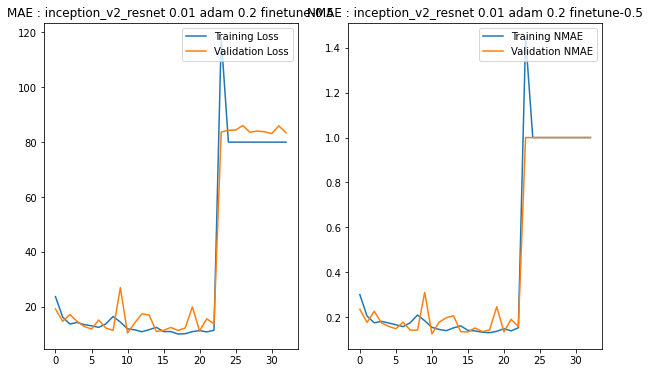

Epoch 1/2000
67/67 [==============================] - 82s 1s/step - loss: 24179.9328 - nmae: 236.4196 - val_loss: 94.5878 - val_nmae: 1.2112

Epoch 00001: val_nmae improved from inf to 1.21116, saving model to ./Best_Check_Point/best_params1_finetune_0.3.ckpt
Epoch 2/2000
67/67 [==============================] - 66s 985ms/step - loss: 104.9681 - nmae: 1.4989 - val_loss: 85.4963 - val_nmae: 1.0000

Epoch 00002: val_nmae improved from 1.21116 to 1.00000, saving model to ./Best_Check_Point/best_params1_finetune_0.3.ckpt
Epoch 3/2000
67/67 [==============================] - 66s 985ms/step - loss: 77.6283 - nmae: 1.0000 - val_loss: 84.8209 - val_nmae: 1.0000

Epoch 00003: val_nmae did not improve from 1.00000
Epoch 4/2000
67/67 [==============================] - 67s 987ms/step - loss: 79.7925 - nmae: 0.9999 - val_loss: 84.7748 - val_nmae: 1.0000

Epoch 00004: val_nmae did not improve from 1.00000
Epoch 5/2000
67/67 [==============================] - 66s 985ms/step - loss: 79.1467 - nmae: 0.

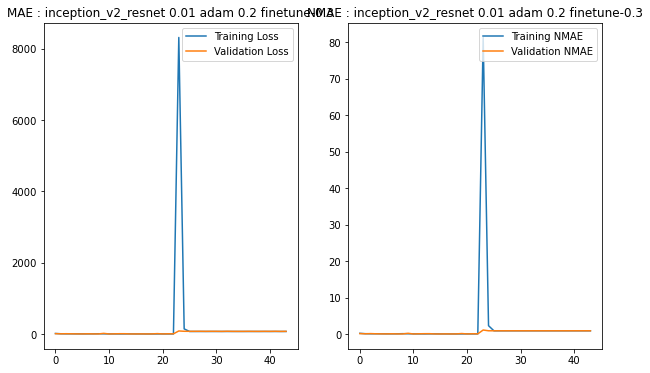

In [16]:
for freeze_rate in [0.9, 0.7, 0.5, 0.3] :
    model.load_weights('./Best_Check_Point/best_params1_top_layers.ckpt')
    
    base_model.trainable=True
    fine_tune_at = int(len(base_model.layers) * freeze_rate)
    for layer in base_model.layers[:fine_tune_at] :
        layer.trainable = False    
        
    model.compile(optimizer=Adam(0.001),
            loss='mae',
            metrics=[nmae])

    es = EarlyStopping(monitor='loss',
                    mode='auto',
                    patience=5,
                    verbose=1)

    ckpt_path = './Best_Check_Point/best_params1_finetune_{}.ckpt'.format(freeze_rate)
    checkpointer = ModelCheckpoint(filepath=ckpt_path,
                                  monitor='val_nmae',
                                  save_weights_only = True,
                                  save_best_only= True,
                                  verbose=1)

    STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
    VAL_STEPS = len(valid_img) // BATCH_SIZE

    history_fine = model.fit(train_generator, epochs=2000,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=valid_generator,
                      validation_steps = VAL_STEPS,
                      callbacks=[checkpointer, es],
                      verbose=1)
    
    model.save('./Model_Save/best_params1_finetune_{}.h5'.format(freeze_rate))
    model.load_weights(ckpt_path)
    model.save('./Model_Save/best_params1_finetune_{}_2.h5'.format(freeze_rate))
    
    history_dict[str(freeze_rate)] = history_fine
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss + history_fine.history['loss'], label='Training Loss')
    ax1.plot(valid_loss + history_fine.history['val_loss'], label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(train_nmae + history_fine.history['nmae'], label='Training NMAE')
    ax2.plot(valid_nmae + history_fine.history['val_nmae'], label='Validation NMAE')
    ax2.legend(loc='upper right')
    ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))
    
    plt.show()

<h1> inception_v2_resnet 0.001 adam 0.2 </h1>
<img src='./Training_Result/inception_v2_resnet 0.001 adam 0.2.png'/>

In [17]:
tf.keras.backend.clear_session()

base_model = inception_resnet_v2.InceptionResNetV2(
            weights='imagenet',
            include_top = False,
            input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3))

input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
output_data = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=output_data, name='resize')

# model
inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)
model = Model(inputs, outputs)

base_model.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resize (Functional)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025  

In [18]:
model.compile(optimizer=Adam(0.001),
            loss='mae',
            metrics=[nmae])

es = EarlyStopping(monitor='loss',
                mode='auto',
                patience=5,
                verbose=1)

ckpt_path = './Best_Check_Point/best_params2_top_layers.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_nmae',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
VAL_STEPS = len(valid_img) // BATCH_SIZE

history = model.fit(train_generator, epochs=2000,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  validation_data=valid_generator,
                  validation_steps = VAL_STEPS,
                  callbacks=[checkpointer, es],
                  verbose=1)

model.save('./best2_top_layer.h5')

Epoch 1/2000
67/67 [==============================] - 76s 1s/step - loss: 49.3046 - nmae: 0.6622 - val_loss: 17.7064 - val_nmae: 0.2246

Epoch 00001: val_nmae improved from inf to 0.22463, saving model to ./Best_Check_Point/best_params2_top_layers.ckpt
Epoch 2/2000
67/67 [==============================] - 66s 977ms/step - loss: 18.5583 - nmae: 0.2330 - val_loss: 16.0626 - val_nmae: 0.1896

Epoch 00002: val_nmae improved from 0.22463 to 0.18961, saving model to ./Best_Check_Point/best_params2_top_layers.ckpt
Epoch 3/2000
67/67 [==============================] - 66s 977ms/step - loss: 15.9873 - nmae: 0.1949 - val_loss: 15.6835 - val_nmae: 0.1858

Epoch 00003: val_nmae improved from 0.18961 to 0.18580, saving model to ./Best_Check_Point/best_params2_top_layers.ckpt
Epoch 4/2000
67/67 [==============================] - 65s 975ms/step - loss: 15.7078 - nmae: 0.2023 - val_loss: 15.2492 - val_nmae: 0.1820

Epoch 00004: val_nmae improved from 0.18580 to 0.18200, saving model to ./Best_Check_Po

In [19]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
train_nmae = history.history['nmae']
valid_nmae = history.history['val_nmae']

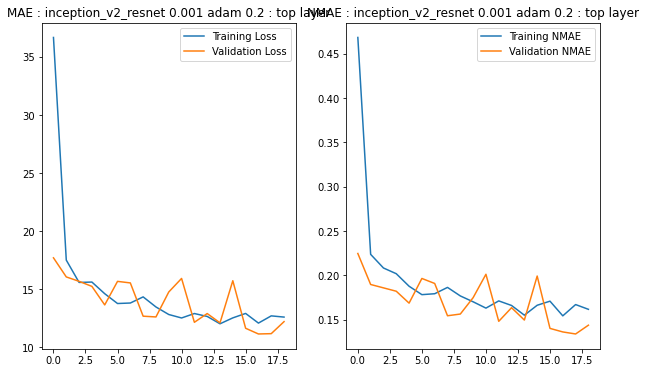

In [20]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
ax1.set_title('MAE : inception_v2_resnet 0.001 adam 0.2 : top layer')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
ax2.set_title('NMAE : inception_v2_resnet 0.001 adam 0.2 : top layer')

plt.show()

### finetune

In [26]:
history_dict2 = {}

Epoch 1/2000
67/67 [==============================] - 77s 1s/step - loss: 20.9423 - nmae: 0.2531 - val_loss: 9.3914 - val_nmae: 0.1166

Epoch 00001: val_nmae improved from inf to 0.11660, saving model to ./Best_Check_Point/best_params2_finetune_0.9.ckpt
Epoch 2/2000
67/67 [==============================] - 67s 990ms/step - loss: 9.8030 - nmae: 0.1259 - val_loss: 8.2994 - val_nmae: 0.1026

Epoch 00002: val_nmae improved from 0.11660 to 0.10261, saving model to ./Best_Check_Point/best_params2_finetune_0.9.ckpt
Epoch 3/2000
67/67 [==============================] - 66s 988ms/step - loss: 9.2183 - nmae: 0.1375 - val_loss: 8.2986 - val_nmae: 0.1013

Epoch 00003: val_nmae improved from 0.10261 to 0.10131, saving model to ./Best_Check_Point/best_params2_finetune_0.9.ckpt
Epoch 4/2000
67/67 [==============================] - 66s 985ms/step - loss: 7.4419 - nmae: 0.0917 - val_loss: 8.3101 - val_nmae: 0.0984

Epoch 00004: val_nmae improved from 0.10131 to 0.09835, saving model to ./Best_Check_Poi

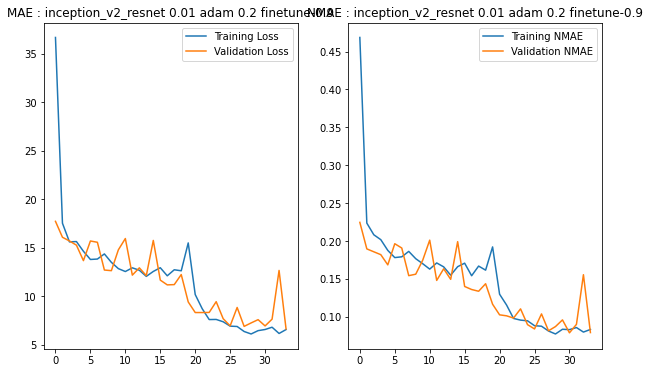

Epoch 1/2000
67/67 [==============================] - 79s 1s/step - loss: 21.6152 - nmae: 0.2714 - val_loss: 18.8186 - val_nmae: 0.2367

Epoch 00001: val_nmae improved from inf to 0.23667, saving model to ./Best_Check_Point/best_params2_finetune_0.7.ckpt
Epoch 2/2000
67/67 [==============================] - 67s 992ms/step - loss: 11.3483 - nmae: 0.1398 - val_loss: 11.9461 - val_nmae: 0.1453

Epoch 00002: val_nmae improved from 0.23667 to 0.14526, saving model to ./Best_Check_Point/best_params2_finetune_0.7.ckpt
Epoch 3/2000
67/67 [==============================] - 67s 993ms/step - loss: 8.6857 - nmae: 0.1111 - val_loss: 9.0626 - val_nmae: 0.1061

Epoch 00003: val_nmae improved from 0.14526 to 0.10612, saving model to ./Best_Check_Point/best_params2_finetune_0.7.ckpt
Epoch 4/2000
67/67 [==============================] - 67s 991ms/step - loss: 8.3423 - nmae: 0.1077 - val_loss: 9.9542 - val_nmae: 0.1175

Epoch 00004: val_nmae did not improve from 0.10612
Epoch 5/2000
67/67 [==============

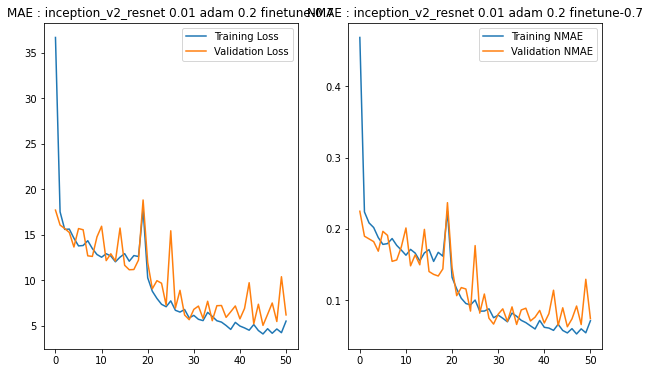

Epoch 1/2000
67/67 [==============================] - 80s 1s/step - loss: 19.9086 - nmae: 0.2649 - val_loss: 8.3858 - val_nmae: 0.1004

Epoch 00001: val_nmae improved from inf to 0.10038, saving model to ./Best_Check_Point/best_params2_finetune_0.5.ckpt
Epoch 2/2000
67/67 [==============================] - 67s 995ms/step - loss: 10.8594 - nmae: 0.1480 - val_loss: 14.1033 - val_nmae: 0.1608

Epoch 00002: val_nmae did not improve from 0.10038
Epoch 3/2000
67/67 [==============================] - 67s 996ms/step - loss: 10.9368 - nmae: 0.1416 - val_loss: 7.8078 - val_nmae: 0.0941

Epoch 00003: val_nmae improved from 0.10038 to 0.09410, saving model to ./Best_Check_Point/best_params2_finetune_0.5.ckpt
Epoch 4/2000
67/67 [==============================] - 67s 991ms/step - loss: 7.2074 - nmae: 0.0932 - val_loss: 7.5886 - val_nmae: 0.0891

Epoch 00004: val_nmae improved from 0.09410 to 0.08912, saving model to ./Best_Check_Point/best_params2_finetune_0.5.ckpt
Epoch 5/2000
67/67 [==============

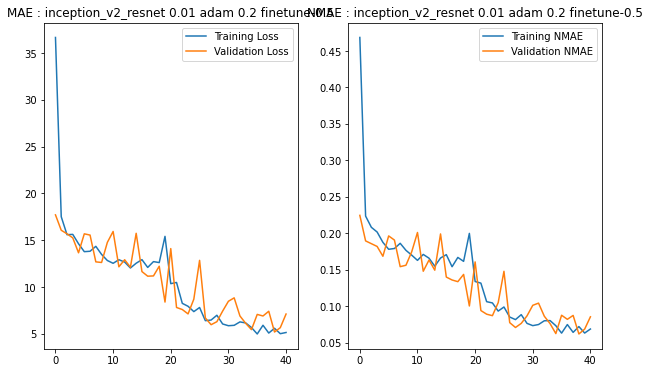

Epoch 1/2000
67/67 [==============================] - 82s 1s/step - loss: 30.6177 - nmae: 0.4576 - val_loss: 14.9125 - val_nmae: 0.1786

Epoch 00001: val_nmae improved from inf to 0.17863, saving model to ./Best_Check_Point/best_params2_finetune_0.3.ckpt
Epoch 2/2000
67/67 [==============================] - 67s 996ms/step - loss: 13.0353 - nmae: 0.1753 - val_loss: 10.7602 - val_nmae: 0.1364

Epoch 00002: val_nmae improved from 0.17863 to 0.13643, saving model to ./Best_Check_Point/best_params2_finetune_0.3.ckpt
Epoch 3/2000
67/67 [==============================] - 67s 998ms/step - loss: 10.6004 - nmae: 0.1251 - val_loss: 8.1027 - val_nmae: 0.0998

Epoch 00003: val_nmae improved from 0.13643 to 0.09980, saving model to ./Best_Check_Point/best_params2_finetune_0.3.ckpt
Epoch 4/2000
67/67 [==============================] - 67s 996ms/step - loss: 7.0098 - nmae: 0.0904 - val_loss: 13.8366 - val_nmae: 0.1650

Epoch 00004: val_nmae did not improve from 0.09980
Epoch 5/2000
67/67 [============

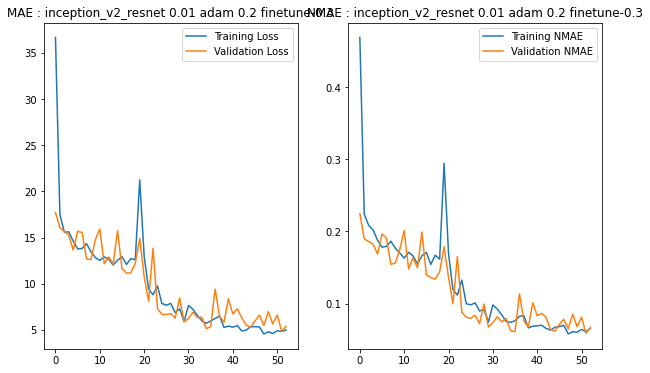

In [27]:
for freeze_rate in [0.9, 0.7, 0.5, 0.3] :
    model.load_weights('./Best_Check_Point/best_params2_top_layers.ckpt')
    
    base_model.trainable=True
    fine_tune_at = int(len(base_model.layers) * freeze_rate)
    for layer in base_model.layers[:fine_tune_at] :
        layer.trainable = False    
        
    model.compile(optimizer=Adam(0.0001),
            loss='mae',
            metrics=[nmae])

    es = EarlyStopping(monitor='loss',
                    mode='auto',
                    patience=5,
                    verbose=1)

    ckpt_path = './Best_Check_Point/best_params2_finetune_{}.ckpt'.format(freeze_rate)
    checkpointer = ModelCheckpoint(filepath=ckpt_path,
                                  monitor='val_nmae',
                                  save_weights_only = True,
                                  save_best_only= True,
                                  verbose=1)

    STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
    VAL_STEPS = len(valid_img) // BATCH_SIZE

    history_fine = model.fit(train_generator, epochs=2000,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=valid_generator,
                      validation_steps = VAL_STEPS,
                      callbacks=[checkpointer, es],
                      verbose=1)
                             
    model.save('./Model_Save/best_params2_finetune_{}.h5'.format(freeze_rate))
    model.load_weights(ckpt_path)
    model.save('./Model_Save/best_params2_finetune_{}_2.h5'.format(freeze_rate))
    
    history_dict2[str(freeze_rate)] = history_fine
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss + history_fine.history['loss'], label='Training Loss')
    ax1.plot(valid_loss + history_fine.history['val_loss'], label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(train_nmae + history_fine.history['nmae'], label='Training NMAE')
    ax2.plot(valid_nmae + history_fine.history['val_nmae'], label='Validation NMAE')
    ax2.legend(loc='upper right')
    ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))
    
    plt.show()